In [45]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
from torchvision.transforms import v2

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import random


In [46]:
df_train = pd.read_csv('../../data/sign_mnist_train.csv')
df_test = pd.read_csv('../../data/sign_mnist_test.csv')

df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [47]:
y_train = df_train['label'].values
X_train = df_train.drop('label', axis=1).values

y_test = df_test['label'].values
X_test = df_test.drop('label', axis=1).values

In [48]:
# Normalize the data
X_train = X_train / 255
X_test = X_test / 255

# Reshape the data
X_train = X_train.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)

In [49]:
# Générer un vecteur d'indices aléatoires de taille n entre 0 et len(X_train)-1
def random_indices(n, X_train):
    return random.sample(range(0, len(X_train)-1), n)

l = len(X_train)
n = 0.1*l

# On separera les données en 2 groupes, un pour l'entrainement et un pour la validation
# On prendra 10% des données pour la validation

indices = random_indices(int(n), X_train)
X_val = X_train[indices]
y_val = y_train[indices]



In [50]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)


(27455, 1, 28, 28)
(27455,)
(2745, 1, 28, 28)
(2745,)
(7172, 1, 28, 28)
(7172,)


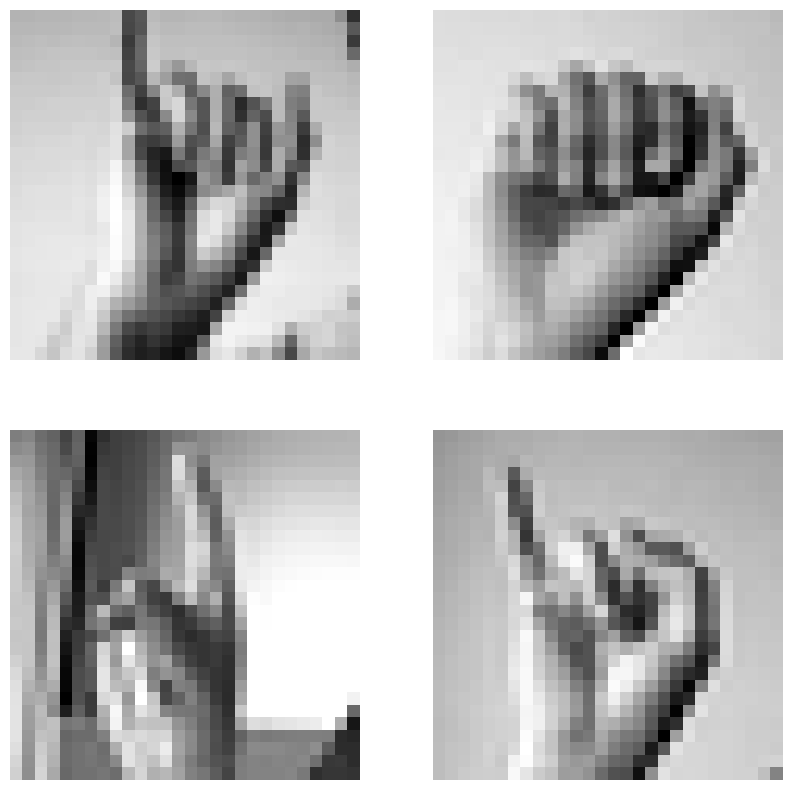

In [51]:
# Afficher 4 images aléatoires

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        ax[i, j].imshow(X_train[random.randint(0, len(X_train))].reshape(28, 28), cmap=cm.gray)
        ax[i, j].axis('off')
plt.show()



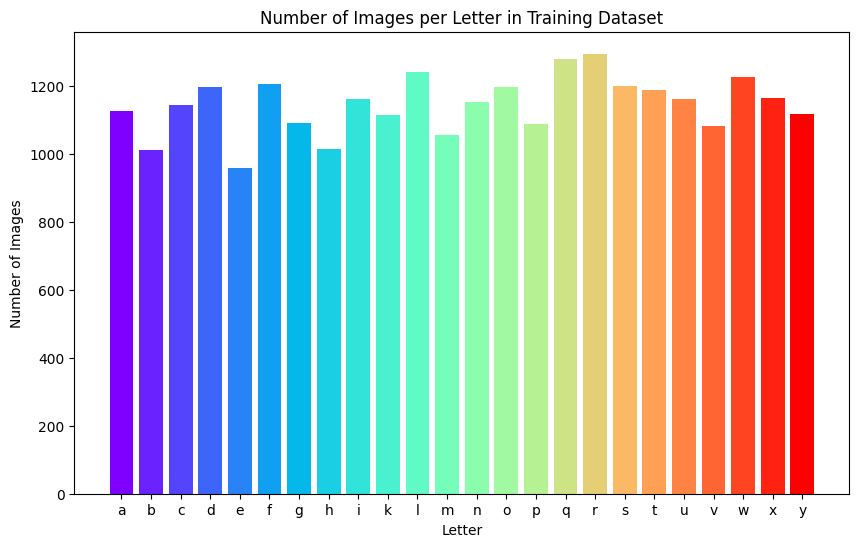

In [52]:
# Visualisation du nombre d'image par classe dans le jeu d'entraînement
letter_counts = {}
for label in y_train:
    letter = chr(label.item() + 97)  # Convertir le label en lettre (97 est le code ASCII pour 'a')
    if letter in letter_counts:
        letter_counts[letter] += 1
    else:
        letter_counts[letter] = 1

sorted_letters = sorted(letter_counts.keys())

# Créer l'histogramme
plt.figure(figsize=(10, 6))
colors = cm.rainbow(np.linspace(0, 1, len(sorted_letters)))
plt.bar(sorted_letters, [letter_counts[letter] for letter in sorted_letters], color=colors)
plt.xlabel('Letter')
plt.ylabel('Number of Images')
plt.title('Number of Images per Letter in Training Dataset')
plt.show()


#### Augmentation des données

In [53]:
data_transforms = v2.Compose([
    v2.RandomRotation(degrees=10),
    v2.RandomHorizontalFlip(p=0.5), 
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Zoom et translation aléatoires
    # Modifie le contraste de maniere aleatoire
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    # Modifie la luminosite de maniere aleatoire
    v2.RandomGrayscale(p=0.1),
    #v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485], std=[0.225])
])

# Creation de nos Tenseurs de données

In [54]:
torch_X_train = torch.from_numpy(X_train).float()
torch_y_train = torch.from_numpy(y_train).long()
torch_X_val = torch.from_numpy(X_val).float()
torch_y_val = torch.from_numpy(y_val).long()
torch_X_test = torch.from_numpy(X_test).float()
torch_y_test = torch.from_numpy(y_test).long()

In [55]:

percentage_of_augmented_data = 100 # 100 to double the amount of data
random_integers = random.sample(range(torch_X_train.size()[0]), int((percentage_of_augmented_data)/100*torch_X_train.size()[0]))


# Créer une liste pour stocker les nouveaux objets
new_images = []
new_labels = []

# Parcourir les indices aléatoires
for i in random_integers:
    img = torch_X_train[i]
    transformed_img = data_transforms(img)
    
    # Ajouter l'image transformée à la liste
    new_images.append(transformed_img.unsqueeze(0))
    
    # Ajouter l'étiquette correspondante à la liste
    new_labels.append(torch_y_train[i].unsqueeze(0))

print(torch_X_train.size())
# Concaténer les nouvelles images et étiquettes avec les données d'origine
if new_images:
    new_images = torch.cat(new_images, dim=0)
    new_labels = torch.cat(new_labels, dim=0)

    torch_X_train = torch.cat((torch_X_train, new_images), dim=0)
    torch_y_train = torch.cat((torch_y_train, new_labels), dim=0)

print(torch_X_train.size())

torch.Size([27455, 1, 28, 28])
torch.Size([54910, 1, 28, 28])


In [56]:
history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'val_loss': [], 'val_acc': []}

In [57]:
BATCH_SIZE = 50

In [58]:
import torch.nn as nn

def evaluate(model, dataloader):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    loss = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            loss += loss_fn(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return loss / len(dataloader), correct / total

In [59]:
# def fit(model, train_loader, test_loader):
#     optimizer = torch.optim.Adam(model.parameters())
#     loss_fn = nn.CrossEntropyLoss()
#     epochs = 15
#     model.train()
#     for epoch in range(epochs):
#         correct = 0
#         for batch_id , (X_batch, y_batch) in enumerate(train_loader):
#             var_X_batch = Variable(X_batch).float()
#             var_y_batch = Variable(y_batch)
#             optimizer.zero_grad()
#             output = model(var_X_batch)
#             loss = loss_fn(output, var_y_batch)
#             loss.backward()
#             optimizer.step()

#             # Compte le nombre de prédictions correctes
#             prediction = torch.max(output.data, 1)[1] 
#             correct += (prediction == var_y_batch).sum()
#             if batch_id % 50 == 0:
#                 print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
#                     epoch, batch_id*len(X_batch), len(train_loader.dataset), 100.*batch_id / len(train_loader), loss.data, float(correct*100) / float(BATCH_SIZE*(batch_id+1))))
#             # if float(correct*100) / float(BATCH_SIZE*(batch_id+1)) > 90:
#             #     break
#         history['train_loss'].append(loss)
#         history['train_acc'].append(float(correct) / float(len(train_loader.dataset)))
#         test_loss, test_acc = evaluate(model, test_loader)
#         history['test_loss'].append(test_loss)
#         history['test_acc'].append(test_acc)



In [60]:
def fit(model, train_loader, test_loader, val_loader, history):
    """
    Entraîne le modèle sur les données d'entraînement et évalue les performances sur les données de test à chaque époque.

    Args:
        model (torch.nn.Module): Le modèle à entraîner.
        train_loader (torch.utils.data.DataLoader): Le chargeur de données pour les données d'entraînement.
        test_loader (torch.utils.data.DataLoader): Le chargeur de données pour les données de test.
    """

    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    epochs = 25
    model.train()

    print("Taille du dataset : " + str(len(train_loader.dataset)))


    for epoch in range(epochs):
        train_loss = 0.0
        correct = 0

        # Évaluation du modèle sur les données de validation
        val_loss, val_acc = evaluate(model, val_loader)

        # Enregistrement des performances de validation
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        for batch_id, (X_batch, y_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(X_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()

            # Compte le nombre de prédictions correctes
            prediction = torch.argmax(output, dim=1)
            correct += (prediction == y_batch).sum().item()

            train_loss += loss.item()

            if batch_id % 50 == 0:
                print(f'Epoch: {epoch + 1} [{batch_id * len(X_batch)}/{len(train_loader.dataset)}'
                      f' ({100. * batch_id / len(train_loader):.0f}%)]\tLoss: {train_loss / (batch_id + 1):.6f}')

        # Enregistrement des performances d'entraînement
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(correct / len(train_loader.dataset))

    
        # Évaluation du modèle sur les données de test
        test_loss, test_acc = evaluate(model, test_loader)
        # Enregistrement des performances de test
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

    return history


In [61]:
# Nous devons redimensionner les données pour les passer dans le réseau de neurones convolutif
torch_X_train = torch_X_train.view(-1, 1,28,28).float()
torch_X_test = torch_X_test.view(-1,1,28,28).float()
torch_X_val = torch_X_val.view(-1,1,28,28).float()

train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)
val = torch.utils.data.TensorDataset(torch_X_val, torch_y_val)

# charge les données dans le DataLoader de PyTorch
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)
val_loader = torch.utils.data.DataLoader(val, batch_size = BATCH_SIZE, shuffle = False)

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(p=0.25)
        
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout2d(p=0.25)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1568, 256)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 25)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

cnn = ConvNet()
print(cnn)



ConvNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1568, out_features=256, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=25, bias=True)
)


In [63]:
def save_model(model, filename):
    torch.save(model.state_dict(), filename)

In [64]:
fit(cnn,train_loader, test_loader, val_loader, history)

Taille du dataset : 54910
Epoch: 1 [0/54910 (0%)]	Loss: 3.215729
Epoch: 1 [2500/54910 (5%)]	Loss: 3.179965
Epoch: 1 [5000/54910 (9%)]	Loss: 3.069466
Epoch: 1 [7500/54910 (14%)]	Loss: 2.775472
Epoch: 1 [10000/54910 (18%)]	Loss: 2.475714
Epoch: 1 [12500/54910 (23%)]	Loss: 2.231206
Epoch: 1 [15000/54910 (27%)]	Loss: 2.018341
Epoch: 1 [17500/54910 (32%)]	Loss: 1.837550
Epoch: 1 [20000/54910 (36%)]	Loss: 1.696884
Epoch: 1 [22500/54910 (41%)]	Loss: 1.572910
Epoch: 1 [25000/54910 (45%)]	Loss: 1.468783
Epoch: 1 [27500/54910 (50%)]	Loss: 1.376606
Epoch: 1 [30000/54910 (55%)]	Loss: 1.294632
Epoch: 1 [32500/54910 (59%)]	Loss: 1.222992
Epoch: 1 [35000/54910 (64%)]	Loss: 1.162355
Epoch: 1 [37500/54910 (68%)]	Loss: 1.103467
Epoch: 1 [40000/54910 (73%)]	Loss: 1.055482
Epoch: 1 [42500/54910 (77%)]	Loss: 1.010255
Epoch: 1 [45000/54910 (82%)]	Loss: 0.968190
Epoch: 1 [47500/54910 (86%)]	Loss: 0.930162
Epoch: 1 [50000/54910 (91%)]	Loss: 0.895642
Epoch: 1 [52500/54910 (96%)]	Loss: 0.864068
Epoch: 2 [0/5491

{'train_loss': [0.8355191098805771,
  0.1337123501056922,
  0.0775836808619164,
  0.04939544359604456,
  0.04518247896587352,
  0.035776757837923154,
  0.031636771198760245,
  0.02805464442004529,
  0.02795891944619403,
  0.01899245505028193,
  0.024452687610562355,
  0.019402289707578232,
  0.021091006188126184,
  0.021185137997844546,
  0.015601314801083916,
  0.015140330213572138,
  0.017351402253838626,
  0.016413627277149737,
  0.01587720452537205,
  0.01302988348137109,
  0.017318222224279565,
  0.01153871056902244,
  0.014960178547460384,
  0.013305100864209185,
  0.01436117189185453],
 'train_acc': [0.7368056820251321,
  0.9566563467492261,
  0.9742487707157166,
  0.9840284101256602,
  0.9850482607903842,
  0.9881988708796212,
  0.9901475141140047,
  0.9904206883991987,
  0.9910580950646513,
  0.9942815516299399,
  0.9926425059187762,
  0.9943543981059916,
  0.9936441449644874,
  0.9941904935348752,
  0.9956292114368968,
  0.9953560371517027,
  0.994791476962302,
  0.9952467674

In [65]:
evaluate(cnn, test_loader)

(0.062098884434211264, 0.9846625766871165)

In [67]:
print(history['train_loss'])
print(history['test_loss'])
print(history['train_acc'])
print(history['test_acc'])


[0.8355191098805771, 0.1337123501056922, 0.0775836808619164, 0.04939544359604456, 0.04518247896587352, 0.035776757837923154, 0.031636771198760245, 0.02805464442004529, 0.02795891944619403, 0.01899245505028193, 0.024452687610562355, 0.019402289707578232, 0.021091006188126184, 0.021185137997844546, 0.015601314801083916, 0.015140330213572138, 0.017351402253838626, 0.016413627277149737, 0.01587720452537205, 0.01302988348137109, 0.017318222224279565, 0.01153871056902244, 0.014960178547460384, 0.013305100864209185, 0.01436117189185453]
[0.1972423638475852, 0.24788544550796765, 0.08640415004790863, 0.09929038322459544, 0.09058998993552653, 0.0642679895196731, 0.07507917517129196, 0.0776944671759136, 0.07386429314040772, 0.07653546735269225, 0.07134608675874511, 0.049924541209394296, 0.06145590904149382, 0.06966752104280102, 0.04918295274284093, 0.04303302320527615, 0.0468035274346524, 0.10249379936294645, 0.09029743694393094, 0.03189985391933684, 0.06739774176301377, 0.03223119622473152, 0.03

In [68]:
save_model(cnn, 'model_5x5_170524.pth')

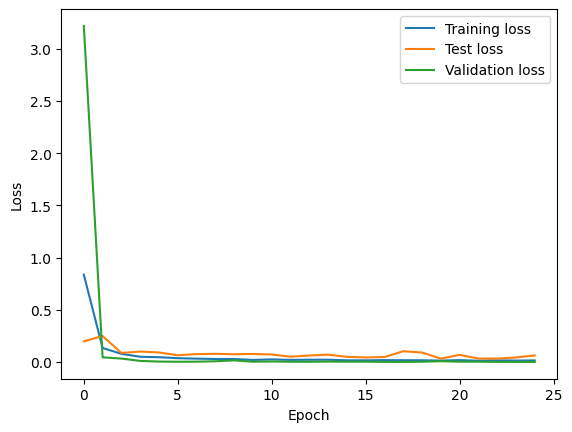

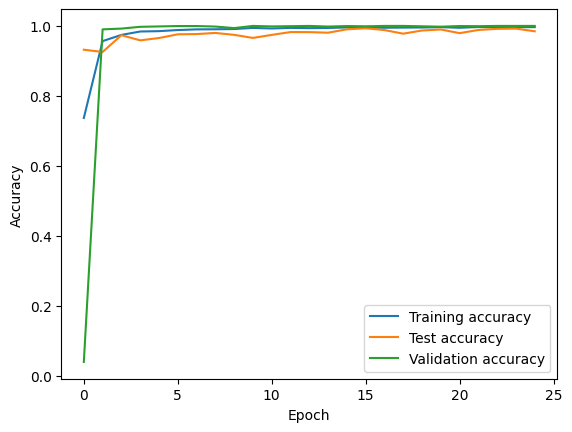

In [70]:
# Afficher la perte d'entraînement et de test
plt.figure()
plt.plot(history['train_loss'], label='Training loss')
plt.plot(history['test_loss'], label='Test loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Tracer la précision d'entraînement et de test
plt.figure()
plt.plot(history['train_acc'], label='Training accuracy')
plt.plot(history['test_acc'], label='Test accuracy')
plt.plot(history['val_acc'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [73]:
def evaluate2(model, data_loader, device):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
    test_loss /= len(data_loader.dataset)
    test_acc = 100 * correct / len(data_loader.dataset)
    return test_loss, test_acc

evaluate2(cnn, test_loader, 'cpu')

(0.0012468264582440633, 98.46625766871166)

avec le modèle ConvNet et batch à 32 (sans data augmentation): test accuracy : 0.958%   
avec le modèle ConvNet et batch à 128 (sans data augmentation): test accuracy : 0.929%  
avec le modèle ConvNet et batch à 32 (avec data augmentation): test accuracy : 0.983%

In [74]:
# Fonction pour afficher les poids des filtres
def visualize_conv_weights(weights, title):
    n_filters = weights.shape[0]
    n_channels = weights.shape[1]
    
    # Calcul de la disposition de la grille
    grid_size = int(np.ceil(np.sqrt(n_filters)))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*2, grid_size*2))
    fig.suptitle(title)
    
    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            img = weights[i, 0].detach().numpy()
            img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalisation
            ax.imshow(img, cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')  # Masquer les axes inutilisés
    plt.show()

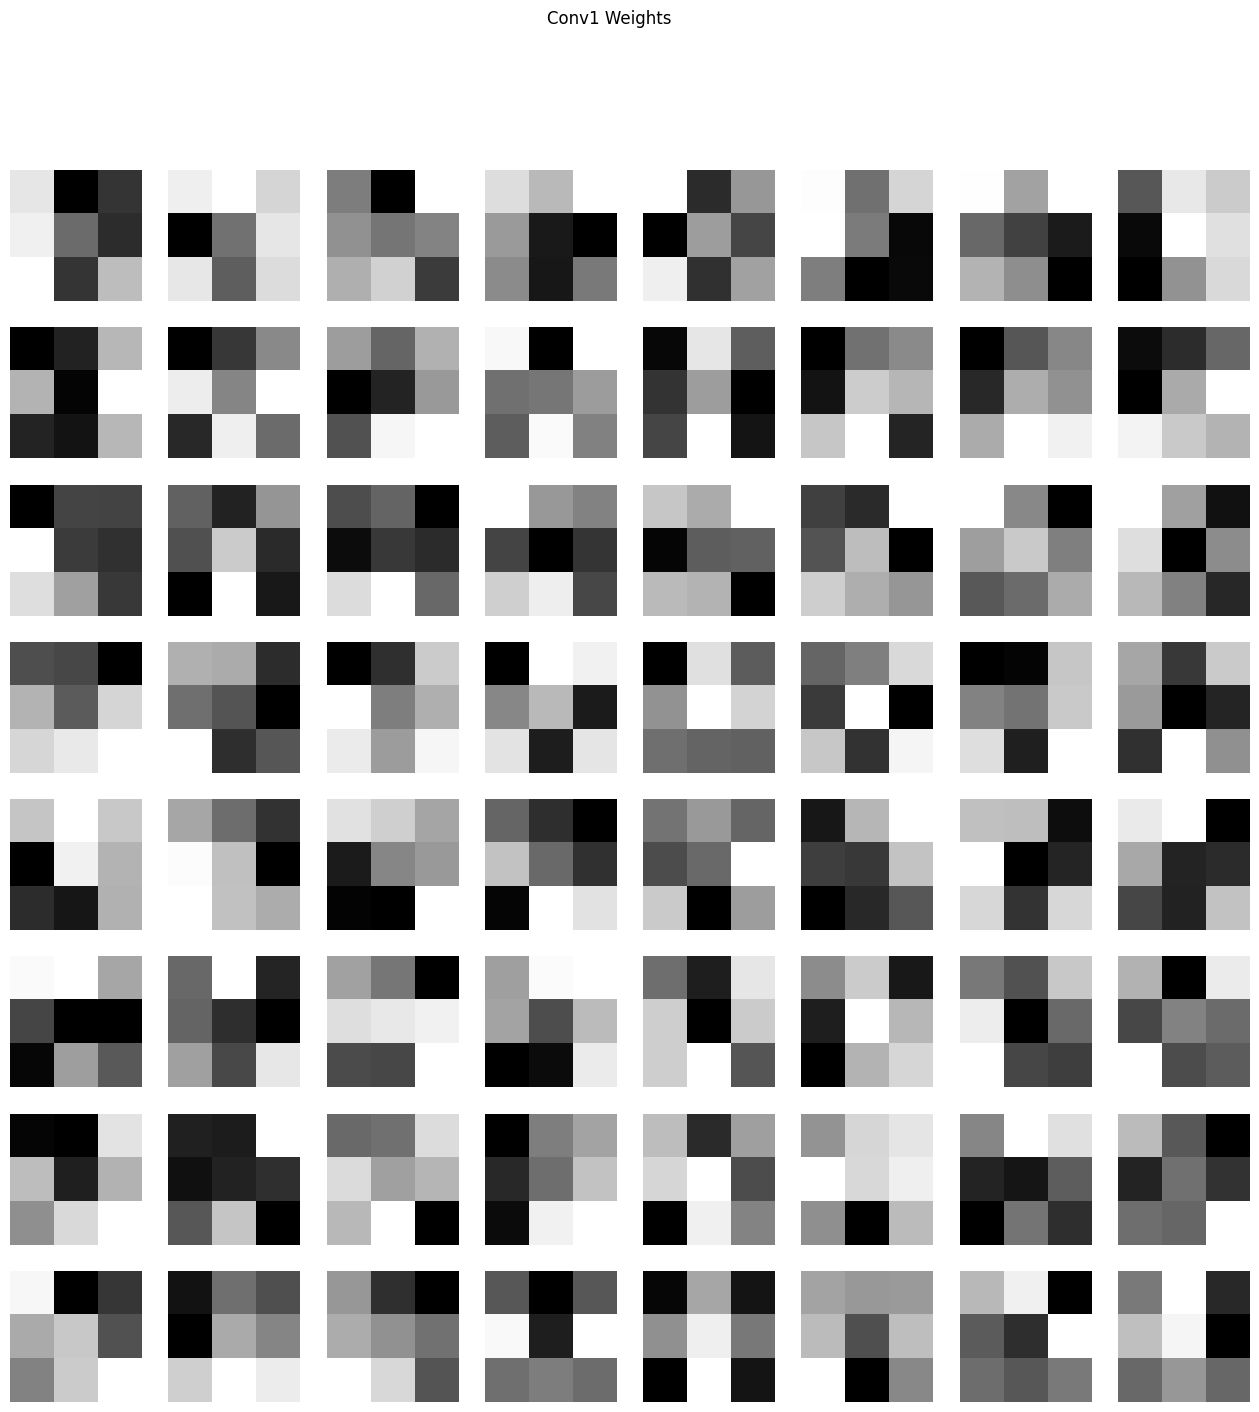

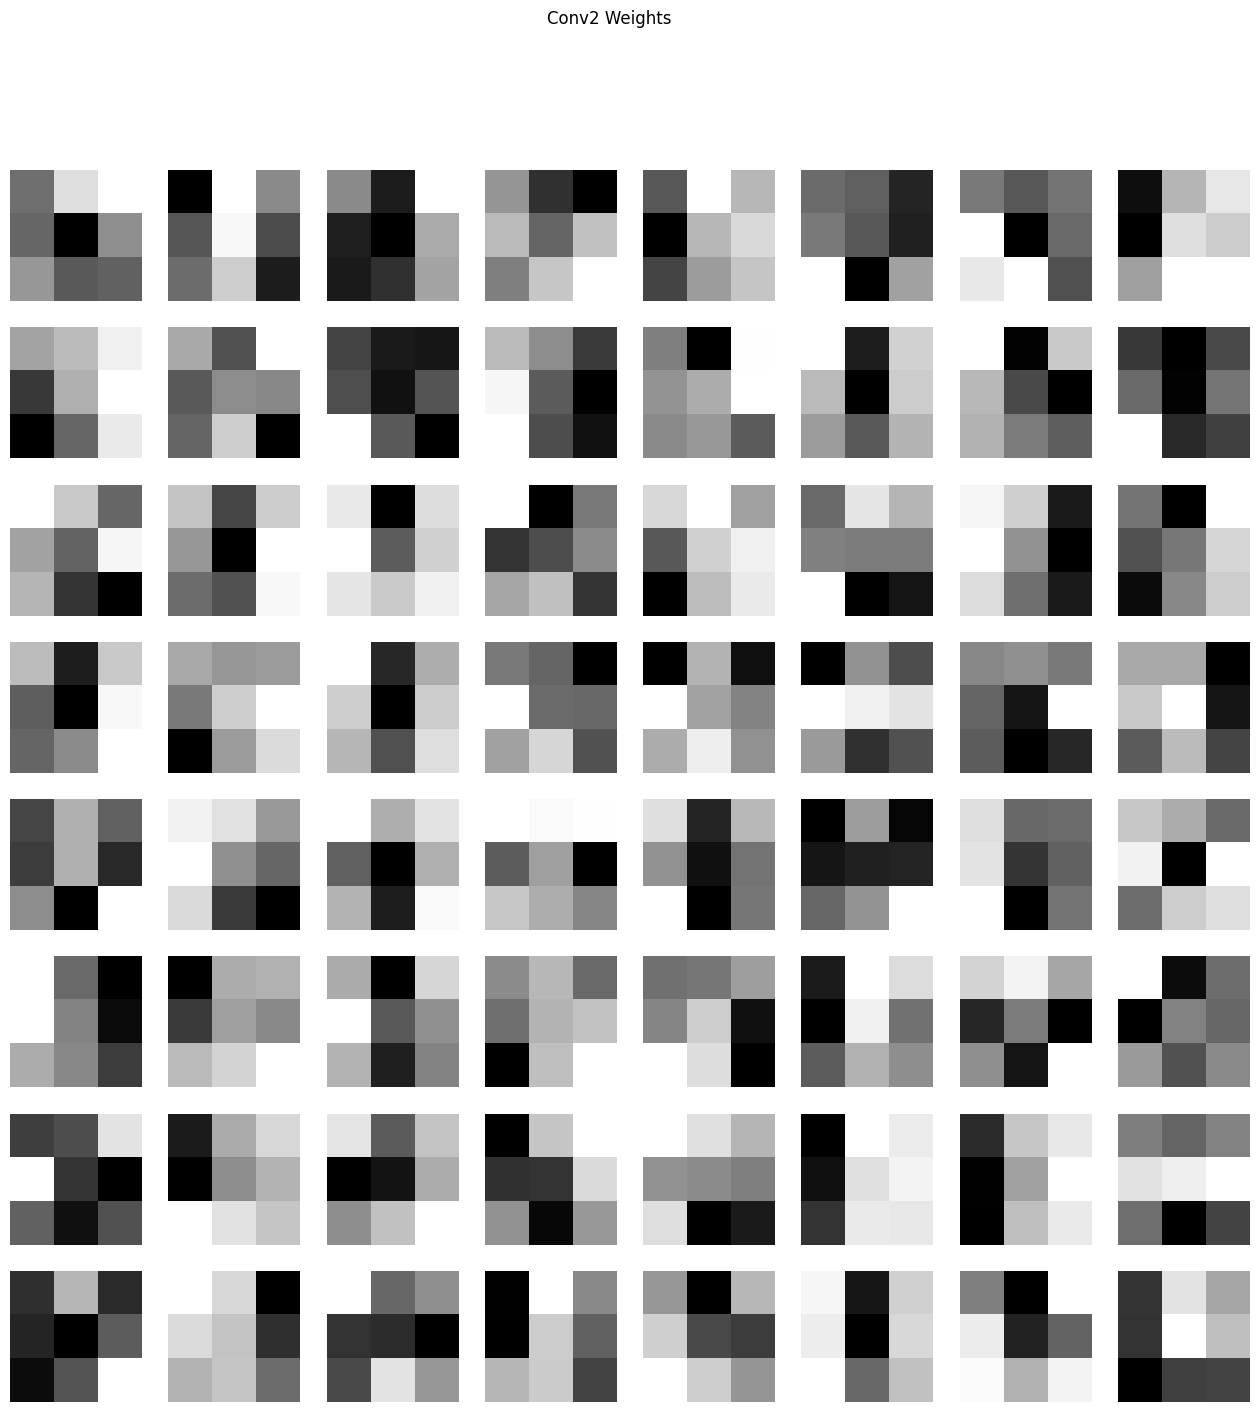

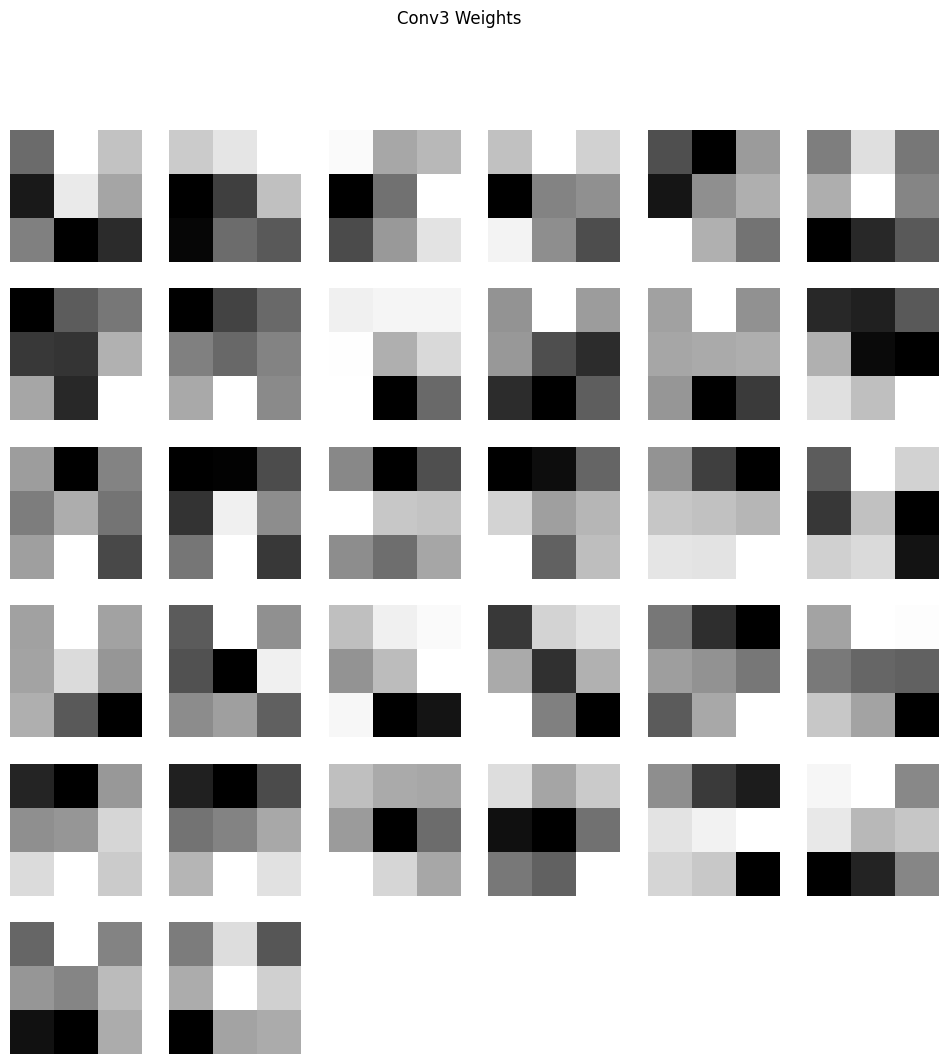

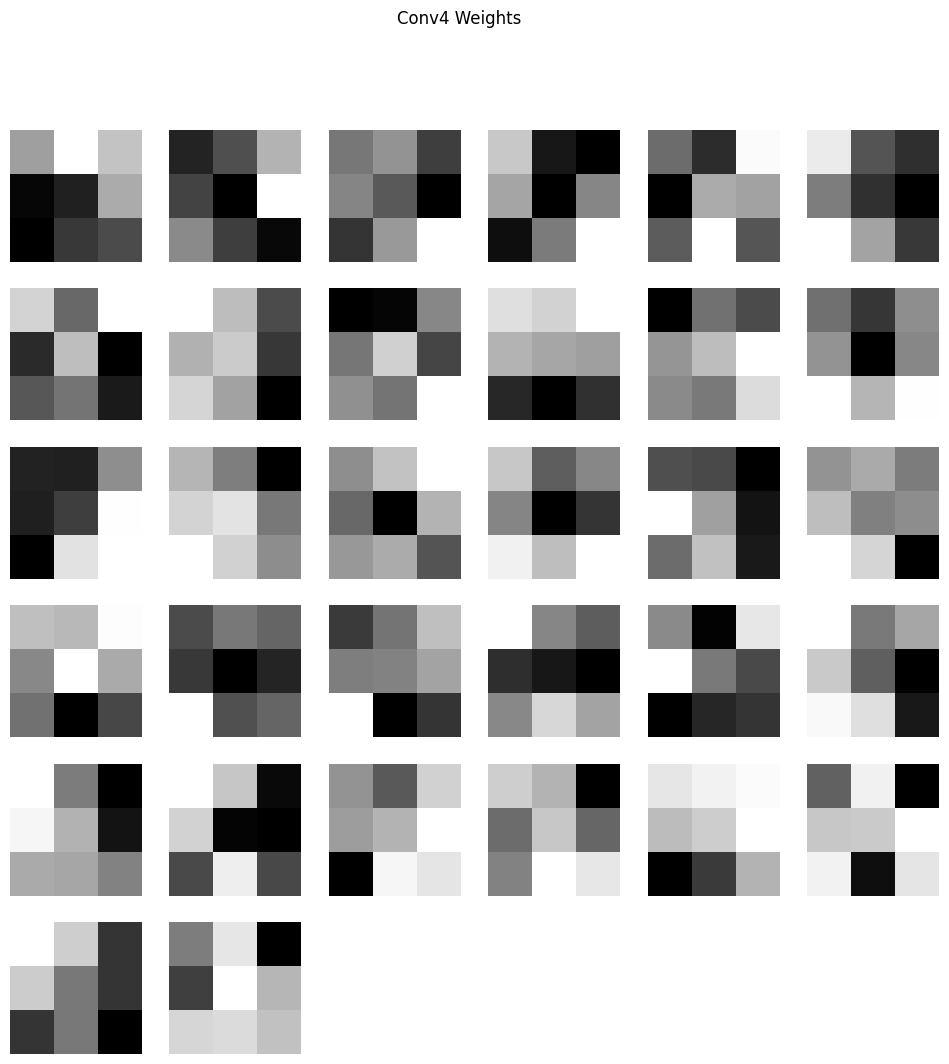

In [76]:
# Affichage des poids des filtres de la première couche de convolution
conv1_weights = cnn.conv1.weight
visualize_conv_weights(conv1_weights, "Conv1 Weights")
# Affichage des poids des filtres de la 2e couche de convolution
conv2_weights = cnn.conv2.weight
visualize_conv_weights(conv2_weights, "Conv2 Weights")
# Affichage des poids des filtres de la 3e couche de convolution
conv3_weights = cnn.conv3.weight
visualize_conv_weights(conv3_weights, "Conv3 Weights")
# Affichage des poids des filtres de la 4e couche de convolution
conv4_weights = cnn.conv4.weight
visualize_conv_weights(conv4_weights, "Conv4 Weights")